In [1]:
import torch
from classes.MyModel import MyModel

from modules.helper_functions_tsp import (find_problem_size, 
                                          cost_fn_fact, 
                                          cost_fn_tensor,
                                          read_index, 
                                          hot_start, 
                                          hot_start_list_to_string,
                                          update_parameters_using_gradient, 
                                          define_parameters, 
                                          create_initial_rotations,
                                          bind_weights, 
                                          vqc_circuit, 
                                          cost_func_evaluate, 
                                          find_run_stats,
                                          find_distances_array,
                                          #format_boolean,
                                          )

from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model
                                         )

from classes.MyDataLogger import MyDataLogger, MySubDataLogger

import copy
import time
from pathlib import Path

from modules.config import(CONTROL_DIR, 
                           CONTROL_FILE, 
                           ENCODING, 
                           #CACHE_MAX_SIZE
                           )

Load control data.

In [2]:
control_path = Path(CONTROL_DIR).joinpath(CONTROL_FILE)
control_dict = read_index(control_path, ENCODING)
print(f'Reading control data from {control_path}')
print(control_dict)
EMPTY = ' '

Reading control data from control\control_parameters.csv
{0: {'quantum': 'FALSE', 'locations': '6', 'slice': '1', 'shots': '64', 'mode': '2', 'iterations': '50', 'gray': 'FALSE', 'hot_start': 'FALSE', 'gradient_type': 'SGD', 'formulation': 'original', 'layers': '2', 'std_dev': '0.01', 'lr': '0.0001', 'weight_decay': '0.0002', 'momentum': '0', 'alpha': '', 'big_a': '', 'c': '', 'eta': '', 'gamma': '', 's': ''}, 1: {'quantum': 'FALSE', 'locations': '6', 'slice': '1', 'shots': '64', 'mode': '2', 'iterations': '50', 'gray': 'FALSE', 'hot_start': 'FALSE', 'gradient_type': 'SGD', 'formulation': 'original', 'layers': '2', 'std_dev': '0.02', 'lr': '0.0001', 'weight_decay': '0.0002', 'momentum': '0', 'alpha': '', 'big_a': '', 'c': '', 'eta': '', 'gamma': '', 's': ''}, 2: {'quantum': 'FALSE', 'locations': '6', 'slice': '1', 'shots': '64', 'mode': '2', 'iterations': '50', 'gray': 'FALSE', 'hot_start': 'FALSE', 'gradient_type': 'SGD', 'formulation': 'original', 'layers': '2', 'std_dev': '0.05', 'l

Instantiate datalogger:

In [3]:
datalogger = MyDataLogger()

## Main loop

SubDataLogger instantiated.  Run ID = 20250406-16-04-09 - 16-04-09
Reading distance data
Saving data to results\results.csv
Detailed data for Run ID: 20250406-16-04-09 - 16-04-09 successfully added to results\20250406-16-04-09\16-04-09.csv
Graph for Run ID: 20250406-16-04-09-16-04-09 being saved to graphs\20250406-16-04-09\16-04-09.png
SubDataLogger instantiated.  Run ID = 20250406-16-04-09 - 16-04-27
Reading distance data
Saving data to results\results.csv
Detailed data for Run ID: 20250406-16-04-09 - 16-04-27 successfully added to results\20250406-16-04-09\16-04-27.csv
Graph for Run ID: 20250406-16-04-09-16-04-27 being saved to graphs\20250406-16-04-09\16-04-27.png
SubDataLogger instantiated.  Run ID = 20250406-16-04-09 - 16-04-42
Reading distance data
Saving data to results\results.csv
Detailed data for Run ID: 20250406-16-04-09 - 16-04-42 successfully added to results\20250406-16-04-09\16-04-42.csv
Graph for Run ID: 20250406-16-04-09-16-04-42 being saved to graphs\20250406-16-04-09

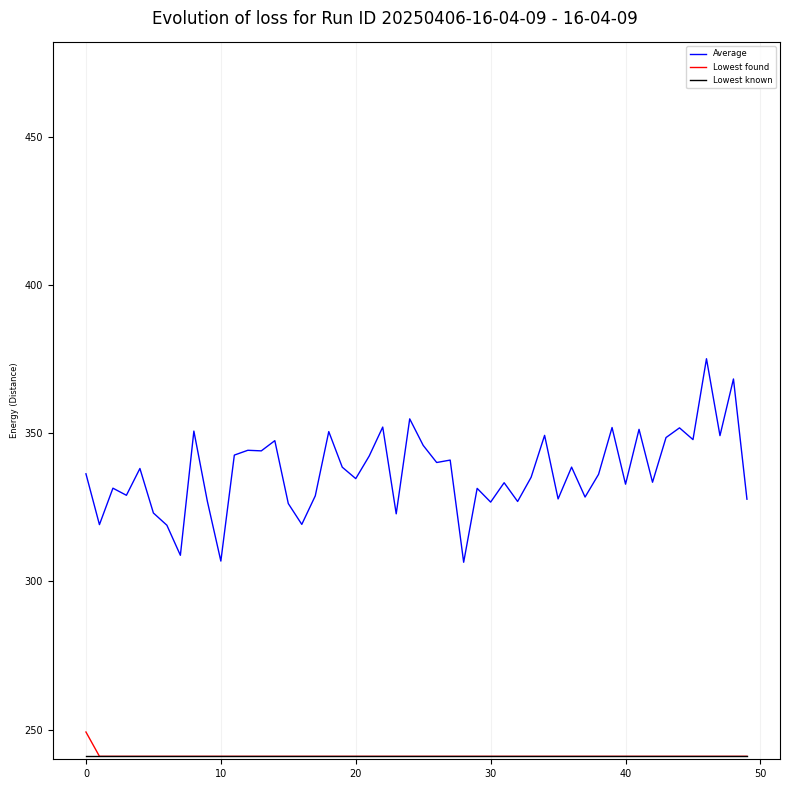

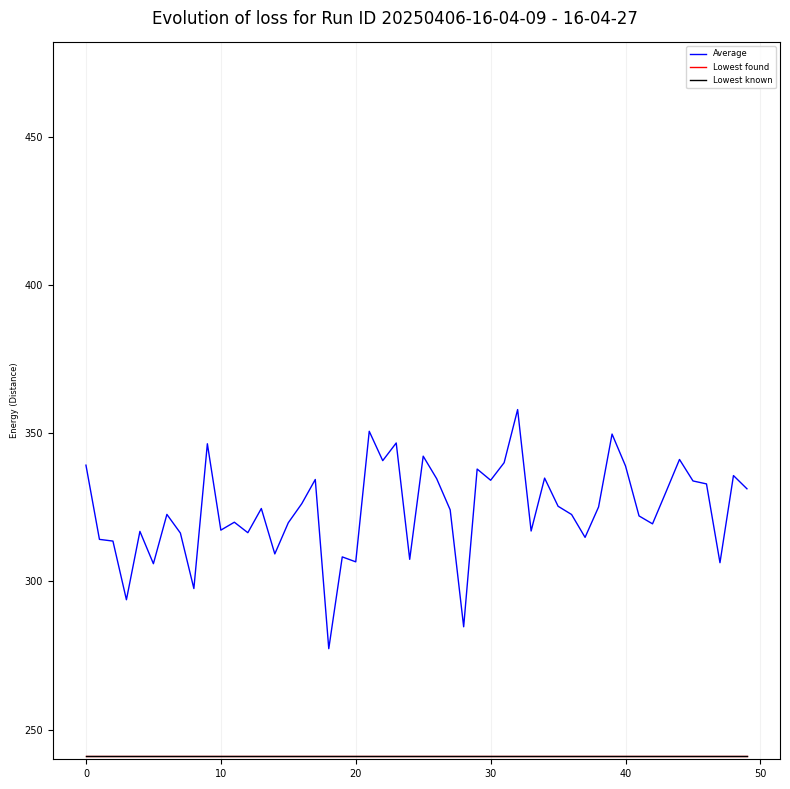

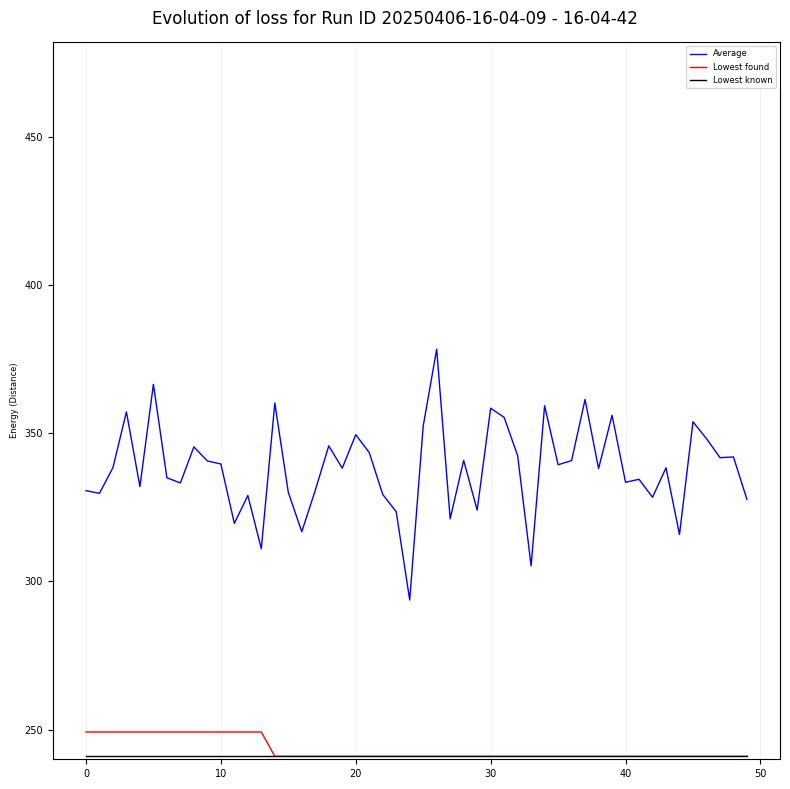

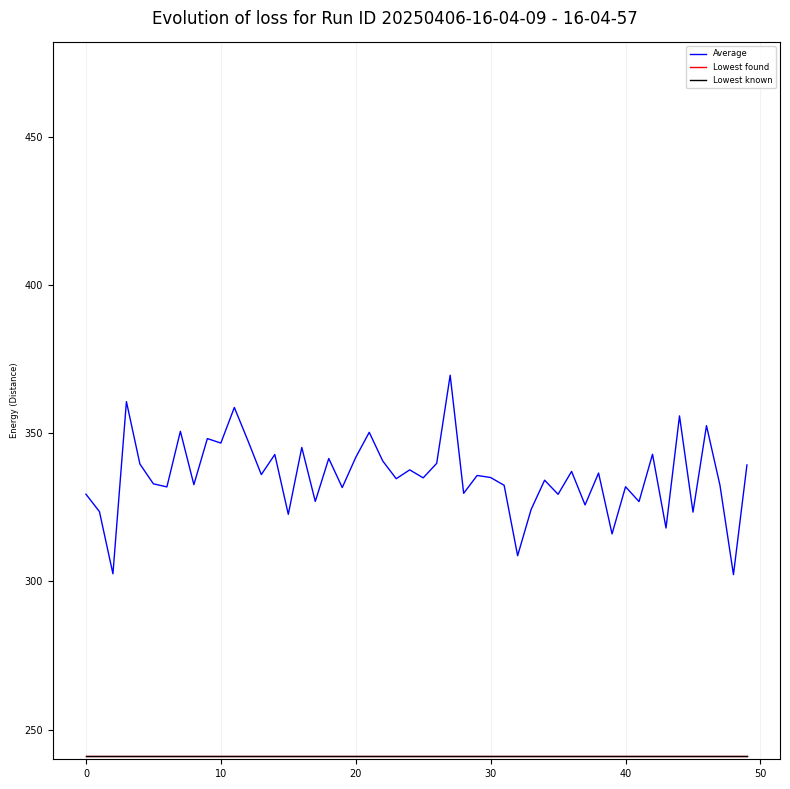

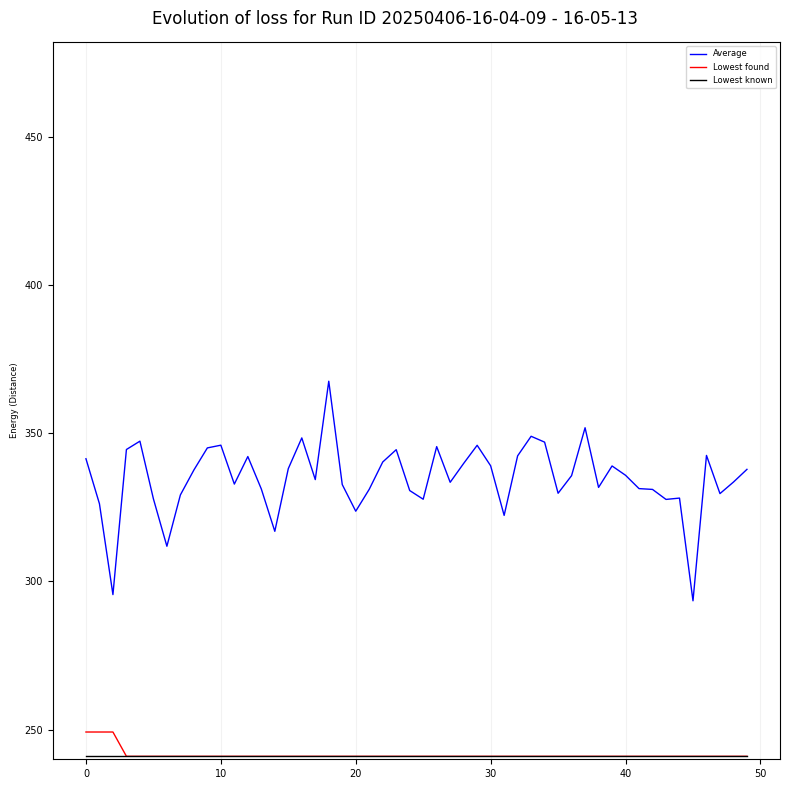

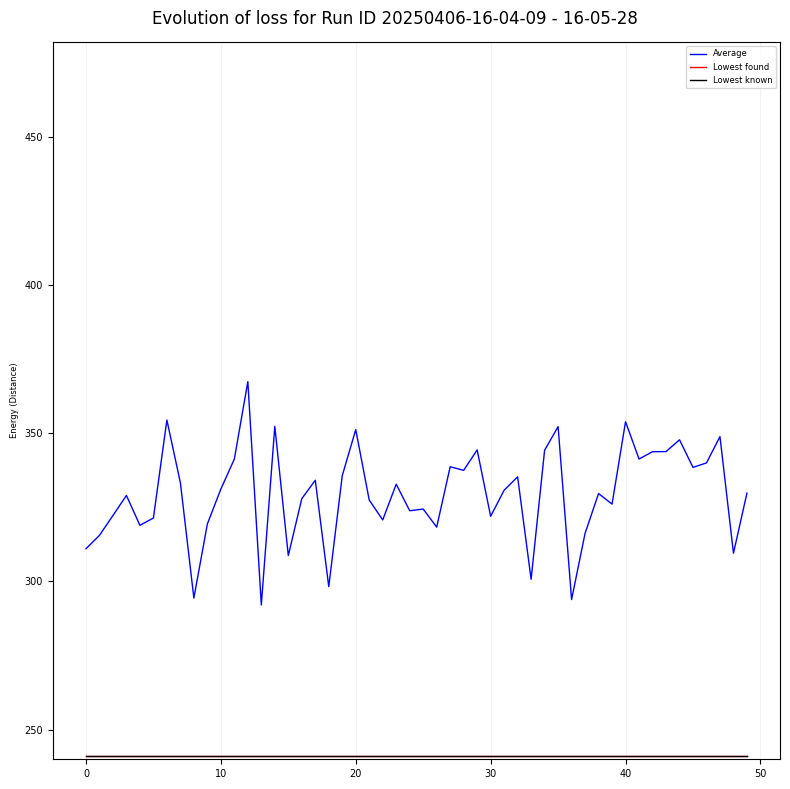

In [4]:
sdl_list = []
for i, control_items in control_dict.items():
    data_dict = dict(control_items)
    sdl_list.append(MySubDataLogger(runid=datalogger.runid))
    sdl_list[i].update_constants_from_dict(data_dict)
    """sdl_list[i].quantum = format_boolean(data_dict['quantum'])
    sdl_list[i].locations = int(data_dict['locations'])
    sdl_list[i].slice = float(data_dict['slice'])
    sdl_list[i].shots = int(data_dict['shots'])
    sdl_list[i].iterations = int(data_dict['iterations'])
    sdl_list[i].gray = format_boolean(data_dict['gray'])
    sdl_list[i].hot_start = format_boolean(data_dict['hot_start'])
    sdl_list[i].gradient_type = data_dict['gradient_type']
    sdl_list[i].formulation = data_dict['formulation']
    if not sdl_list[i].quantum:
        sdl_list[i].layers = int(data_dict['layers'])
        sdl_list[i].std_dev = float(data_dict['std_dev'])
        sdl_list[i].lr = float(data_dict['lr'])
        sdl_list[i].weight_decay = float(data_dict['weight_decay'])
        sdl_list[i].momentum = float(data_dict['momentum'])
    if sdl_list[i].quantum:
        sdl_list[i].mode = int(data_dict['mode'])
        sdl_list[i].alpha = float(data_dict['alpha'])
        sdl_list[i].big_a = float(data_dict['big_a'])
        sdl_list[i].c = float(data_dict['c'])
        sdl_list[i].gamma = float(data_dict['gamma'])
        sdl_list[i].eta = float(data_dict['eta'])
        sdl_list[i].s = float(data_dict['s'])

    sdl_list[i].cache_max_size = CACHE_MAX_SIZE"""


    sdl_list[i].qubits = find_problem_size(sdl_list[i].locations, 
                                           sdl_list[i].formulation
                                           )
    distance_array, best_dist = find_distances_array(sdl_list[i].locations, 
                                                     print_comments=False
                                                     )
    sdl_list[i].best_dist = best_dist 
    
    if sdl_list[i].quantum:
    #Define the VQC circuits with appropriate parameters
        params = define_parameters(sdl_list[i].qubits, 
                                   sdl_list[i].mode
                                   )
        qc = vqc_circuit(sdl_list[i].qubits, 
                         params, 
                         sdl_list[i].mode
                         )
    else:
        device = find_device()

    #define the cost function for this run
    cost_fn = cost_fn_fact(sdl_list[i].locations,
                           distance_array, 
                           sdl_list[i].gray, 
                           method=sdl_list[i].formulation
                           )

    if sdl_list[i].hot_start:
        hot_start_list = hot_start(distance_array, 
                                   sdl_list[i].locations)
        bin_hot_start_list =  hot_start_list_to_string(hot_start_list, 
                                                       sdl_list[i].locations, 
                                                       sdl_list[i].gray, 
                                                       sdl_list[i].formulation
                                                       )
        hot_start_dist = cost_fn(bin_hot_start_list)
        if sdl_list[i].quantum:
            init_rots = create_initial_rotations(sdl_list[i].qubits, 
                                                 sdl_list[i].mode, 
                                                 bin_hot_start_list,
                                                 hot_start=True
                                                 )
        else:
            bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
            unrepeated_input = bin_hot_start_list_tensor.float().to(device)
            my_input = unrepeated_input.repeat(sdl_list[i].shots, 1).requires_grad_(True)
            
    else:
        if sdl_list[i].quantum:
            init_rots = create_initial_rotations(sdl_list[i].qubits, sdl_list[i].mode)
        else:
            unrepeated_input = torch.full((1,sdl_list[i].qubits), 0.5).float().to(device)
            # unrepeated_input = torch.full((sdl_list[i].shots,1), 0.5).float().to(device)
            my_input = unrepeated_input.repeat(sdl_list[i].shots, 1).requires_grad_(True)

    if sdl_list[i].quantum:
        bc = bind_weights(params, init_rots, qc)
        bc.measure_all()
    else:
        model = MyModel(sdl_list[i].qubits, 
                        sdl_list[i].layers, 
                        sdl_list[i].std_dev, 
                        cost_fn).to(device)

    if sdl_list[i].hot_start:
    # find hot start distance
        if sdl_list[i].quantum:
            hot_start_dist, _, _ = cost_func_evaluate(cost_fn, 
                                                      bc, 
                                                      shots=sdl_list[i].shots, 
                                                      average_slice=sdl_list[i].slice)
        else:
            distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, 
                                             cost_fn
                                             ).clone().detach().requires_grad_(True)
            hot_start_dist = float(distance_tensor)

        sdl_list[i].hot_start_dist = hot_start_dist
    else:
        sdl_list[i].hot_start_dist = 'n/a'

    t0 = time.time()
    av_cost_list_all, lowest_list_all, sliced_cost_list_all = [], [], []

    if sdl_list[i].quantum:
        rots = copy.deepcopy(init_rots)
        
        output_data = \
        update_parameters_using_gradient(sdl_list[i],
                                         params=params,
                                         rots=init_rots,
                                         cost_fn=cost_fn,
                                         qc=qc,
                                         verbose=False
                                        )

        sdl_list[i].index_list, sdl_list[i].sliced_list, sdl_list[i].lowest_list, _ , sdl_list[i].average_list, _ = output_data

        sdl_list[i].average_list_all.append(sdl_list[i].average_list)
        sdl_list[i].lowest_list_all.append(sdl_list[i].lowest_list)
        sdl_list[i].sliced_cost_list_all.append(sdl_list[i].sliced_list)

        best_dist_found, iteration_found = find_run_stats(sdl_list[i].lowest_list)

        sdl_list[i].best_dist_found = best_dist_found
        sdl_list[i].iteration_found = iteration_found

    else:
        target, criterion, optimizer = get_ready_to_train(model, 
                                                          sdl_list[i].gradient_type, 
                                                          sdl_list[i].lr, 
                                                          sdl_list[i].weight_decay, 
                                                          momentum = sdl_list[i].momentum,
                                                          )
        
        output_data = train_model(sdl_list[i].iterations,
                                  model, 
                                  my_input, 
                                  target, 
                                  criterion,
                                  optimizer,
                                  )
        
        sdl_list[i].best_dist_found = output_data[0]
        sdl_list[i].iteration_found = output_data[1]
        sdl_list[i].index_list = output_data[2]
        sdl_list[i].average_list = output_data[3]
        sdl_list[i].lowest_list = output_data[4]
        
        sdl_list[i].average_list_all.append(sdl_list[i].average_list)
        sdl_list[i].lowest_list_all.append(sdl_list[i].lowest_list) 
     
    t1 = time.time()
    elapsed = t1-t0
    sdl_list[i].elapsed = elapsed
    sdl_list[i].update_cache_statistics(cost_fn)
    sdl_list[i].save_results_to_csv()
    sdl_list[i].save_detailed_results()
    sdl_list[i].save_plot()